In [1]:
import os, numpy as np, librosa, laion_clap, torch, umap
root='/Users/alexe/Library/Caches/com.bluespoon.ginkgo'
print("scanning for audio files...")
paths = [os.path.join(dp,f) for dp,_,fs in os.walk(root) for f in fs if f.lower().endswith((".wav",".flac",".mp3",".aiff",".aif",".ogg"))]
print(len(paths),'files')

/Users/alexe/dev/ginkgo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanning for audio files...
32894 files


In [2]:
import tqdm
good_paths = []
for path in tqdm.tqdm(paths):
    audio_waveform, _ = librosa.load(path, sr=48000)           
    if len(audio_waveform) < 100:
        print(path, len(audio_waveform))
    else:
        good_paths.append(path)
print("filtered", len(paths)-len(good_paths), "files")
paths=good_paths



 17%|█▋        | 5493/32894 [00:04<00:20, 1313.01it/s]

/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/raw.githubusercontent.com/yaxu/spicule/master/extra-samples/dirty/note-077.wav 0


 18%|█▊        | 5815/32894 [00:04<00:20, 1352.07it/s]

/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/raw.githubusercontent.com/yaxu/spicule/master/extra-samples/jvrave/note-100.wav 0
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/raw.githubusercontent.com/yaxu/spicule/master/extra-samples/jvrave/note-099.wav 0


 86%|████████▌ | 28305/32894 [01:10<00:05, 909.02it/s] 

/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/018-EarthKit.wav 2
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/015-EarthKit.wav 2
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/188-EarthKit.wav 5
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/157-EarthKit.wav 2
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/149-EarthKit.wav 2
/Users/alexe/Library/Caches/com.bluespoon.ginkgo/https__/samples.grbt.com.au/earthkit/195-EarthKit.wav 3


100%|██████████| 32894/32894 [01:24<00:00, 388.58it/s]

filtered 9 files


In [2]:
E_clap = None
F = None
Z = None

In [3]:
paths=None

In [ ]:
model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
model.load_ckpt(root + "/music_audioset_epoch_15_esc_90.14.pt")  # downloaded from HF

In [ ]:
from tqdm import tqdm
batches=[]
for i in tqdm(range(0, len(paths), 100)):
    batch = model.get_audio_embedding_from_filelist(x=paths[i:i+100], use_tensor=False)
    batches.append(batch)
E_clap = np.vstack(batches)
Z = E_clap


In [4]:
if E_clap is not None:
    np.save("E_clap.npy", E_clap)
else:
    E_clap = np.load("E_clap.npy")
if paths is not None:
    np.save("paths.npy", paths)
else:
    paths = np.load("paths.npy")
print(len(paths), len(E_clap))

32885 32885


In [ ]:
def tiny_feats(p):
    y, sr = librosa.load(p, sr=48000, mono=True)
    C = librosa.feature.chroma_cqt(y=y, sr=sr).mean(1)                  # 12
    on = librosa.onset.onset_strength(y=y, sr=sr); trans = [on.mean(), on.std()]  # 2
    spec = librosa.feature.spectral_centroid(y=y, sr=sr).mean()         # 1
    return np.r_[C, trans, spec]                                        # 15D
# tiny features...
use_tiny_feats = False
if use_tiny_feats:
    F = np.vstack([tiny_feats(p) for p in tqdm(paths)])
else:
    F = None

In [5]:
Z = np.hstack([E_clap, F]) if F is not None else E_clap.copy()
Z=Z-Z.mean(0)
Z=Z/Z.std(0)

In [9]:
use_tsne = True
if use_tsne:
    from sklearn.manifold import TSNE
    Z_map = TSNE(n_components=2, perplexity=100, metric="cosine", init="pca").fit_transform(Z)
else:
    Z_map = umap.UMAP(n_neighbors=250, min_dist=0.1, metric="cosine").fit_transform(Z)


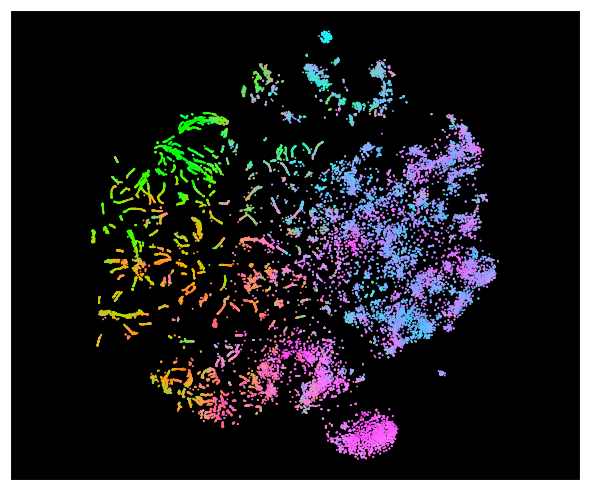

In [10]:
import numpy as np, matplotlib.pyplot as plt

def svd_cbcr_colors(Z, Y=0.5, robust=False):
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    X = U[:, :2] * S[:2]                             # principal scores on top-2
    if robust:
        lo, hi = np.percentile(X, [1, 99], axis=0)
        X = np.clip(X, lo, hi)
    C = (X - X.min(0)) / (X.ptp(0) + 1e-12)          # scale each to [0,1]
    Cb, Cr = C[:,0], C[:,1]

    # YCbCr (BT.601 full-range-ish) -> RGB
    cb, cr = Cb - 0.5, Cr - 0.5
    R = Y + 1.402 * cr
    G = Y - 0.344136 * cb - 0.714136 * cr
    B = Y + 1.772 * cb
    RGB = np.clip(np.c_[R,G,B], 0, 1)
    return RGB

RGB = svd_cbcr_colors(Z, Y=0.7, robust=True)        # set robust=False if you prefer raw min-max

plt.figure(figsize=(6,5))
plt.style.use('dark_background')

plt.scatter(Z_map[:,0], Z_map[:,1], c=RGB, s=2, linewidths=0)
plt.axis('equal'); plt.xticks([]); plt.yticks([]); plt.tight_layout()


4114 very close points
0.2080708038473672


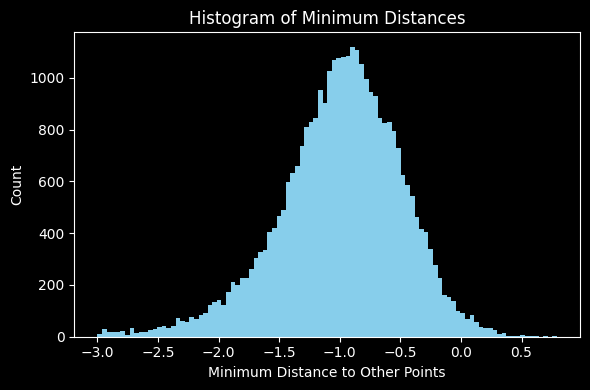

Indices with minimum distance: 26899 30901 0.0010016395536418042
Euclidean distance between Z[i] and Z[j]: 0.0


In [20]:
from scipy.spatial.distance import cdist
dists = cdist(Z_map, Z_map, metric='euclidean')
np.fill_diagonal(dists, np.inf)  # Ignore self-distance
eps=1e-3
print(len(dists[dists < eps]),"very close points")
dists[dists < eps] = np.inf

mindist = np.min(dists, axis=1)
print(mindist[0])
plt.figure(figsize=(6,4))
plt.hist(np.log10(mindist), bins=100, color='skyblue')
plt.xlabel('Minimum Distance to Other Points')
plt.ylabel('Count')
plt.title('Histogram of Minimum Distances')
plt.tight_layout()
plt.show()
# Find indices (i, j) where dists[i, j] is minimum
min_idx = np.unravel_index(np.argmin(dists), dists.shape)
i, j = min_idx
print("Indices with minimum distance:", i, j, dists[i,j])
dist_euc = np.linalg.norm(Z[j] - Z[i])
print("Euclidean distance between Z[i] and Z[j]:", dist_euc)




In [21]:
j = {paths[i].replace(root+'/', '') : Z_map[i].tolist() + RGB[i].tolist() + [mindist[i]] for i in range(len(paths))}
import json
with open('../assets/umap_sounds.json', 'w') as f:
    json.dump(j, f, indent=2)
